In [57]:

## Code for time series analysis adapted from relataly.com example by Florian Müller:
## https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/ 


# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler


from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score




#keep these handy
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



df = pd.read_csv('engineered2.csv')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shortdate           125 non-null    object 
 1   Close               125 non-null    float64
 2   Diff                125 non-null    float64
 3   next_day_close      125 non-null    float64
 4   next_day_diff       125 non-null    float64
 5   next_day_plus_diff  125 non-null    int64  
 6   plus_diff           125 non-null    int64  
 7   comment_count       125 non-null    int64  
 8   rocket              125 non-null    int64  
 9   gem                 125 non-null    int64  
 10  clown               125 non-null    int64  
 11  joy                 125 non-null    int64  
 12  hands               125 non-null    int64  
 13  bear                125 non-null    int64  
 14  gorilla             125 non-null    int64  
 15  money_face          125 non-null    int64  
 16  rofl    

In [59]:
df = df.set_index('shortdate') 

In [60]:
print(df.index)

Index(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-07',
       '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-14',
       ...
       '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
       '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28', '2021-06-29'],
      dtype='object', name='shortdate', length=125)


In [61]:
df.columns

Index(['Close', 'Diff', 'next_day_close', 'next_day_diff',
       'next_day_plus_diff', 'plus_diff', 'comment_count', 'rocket', 'gem',
       'clown', 'joy', 'hands', 'bear', 'gorilla', 'money_face', 'rofl',
       'rainbow', 'flex', 'cry', 'think', 'smile', 'fire', 'eyes', 'upchart',
       'pray', 'downchart', 'mbag', 'plead', 'corn', 'egg', 'drops', 'huff',
       'FD', 'DD', 'YOLO', 'ATH', 'HODL', 'DFV', 'MOON', 'STONKS', 'TENDIES',
       'GAYBEARS', 'BAGHOLDER', 'DIAMONDHANDS', 'PAPERHANDS', 'JPOW',
       'DEGENERATES', 'BTD', 'BHSL', 'HTL', 'WLTS', 'ATS'],
      dtype='object')

In [64]:

# Indexing Batches
train_df = df.sort_values(by=['shortdate']).copy()

# Save a copy of the dates index, before need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
#train_df['Day'] = d.strftime("%d")
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# Reset the index, so can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Close,Diff,next_day_close,next_day_diff,next_day_plus_diff,plus_diff,comment_count,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,plead,corn,egg,drops,huff,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,BTD,BHSL,HTL,WLTS,ATS,Month,Year
0,584.760010,-12.830017,568.820007,12.380005,1,0,1505,20,6,5,9,3,0,0,2,0,0,0,0,5,1,0,1,2,2,1,1,2,0,0,0,2,1,11,8,3,0,0,8,1,10,2,1,4,8,1,0,4,0,2,0,0,12,2020
1,568.820007,12.380005,593.380005,3.359985,1,1,2671,29,13,19,12,2,13,0,3,3,13,2,6,3,4,1,2,0,9,2,3,5,0,1,1,5,5,7,14,10,0,0,18,6,23,1,1,7,3,1,2,3,0,1,0,0,12,2020
2,593.380005,3.359985,599.039978,8.029968,1,1,1309,46,9,6,5,2,5,0,1,1,3,1,1,3,2,0,1,7,1,3,2,1,0,0,0,0,1,3,9,2,0,0,5,2,19,2,0,5,4,0,1,2,0,1,0,0,12,2020
3,599.039978,8.029968,641.760010,36.840027,1,1,1645,34,3,7,6,1,5,1,1,3,3,0,5,2,0,3,1,2,0,1,2,1,0,4,3,1,1,7,6,4,0,0,6,6,8,2,0,1,1,1,1,2,0,1,0,0,12,2020
4,641.760010,36.840027,649.880005,24.369995,1,1,2792,67,5,31,9,3,12,0,4,2,9,2,5,9,6,3,3,3,0,1,3,1,0,1,1,4,6,9,15,7,0,0,8,7,22,1,2,3,5,0,1,8,0,0,0,0,12,2020


In [65]:
date_index

Index(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-07',
       '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-14',
       ...
       '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
       '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28', '2021-06-29'],
      dtype='object', name='shortdate', length=125)

In [66]:
#List of considered Features
FEATURES = ['Close','Diff','plus_diff','comment_count','rocket','gem','clown','joy','hands','bear','gorilla','money_face','rofl','rainbow','flex','cry','think','smile','fire','eyes','upchart','pray','downchart','mbag','plead', 'corn', 'egg', 'drops', 'huff','FD','DD','YOLO','ATH','HODL','DFV','MOON','STONKS','TENDIES','GAYBEARS','BAGHOLDER','DIAMONDHANDS','PAPERHANDS','JPOW','DEGENERATES','BTD', 'BHSL', 'HTL', 'WLTS', 'ATS']

print('FEATURE LIST')
print([f for f in FEATURES]) 

#Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

#hold next_day_plus_diff
data_ndpd = data['next_day_plus_diff']

#add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

#Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'Diff', 'plus_diff', 'comment_count', 'rocket', 'gem', 'clown', 'joy', 'hands', 'bear', 'gorilla', 'money_face', 'rofl', 'rainbow', 'flex', 'cry', 'think', 'smile', 'fire', 'eyes', 'upchart', 'pray', 'downchart', 'mbag', 'plead', 'corn', 'egg', 'drops', 'huff', 'FD', 'DD', 'YOLO', 'ATH', 'HODL', 'DFV', 'MOON', 'STONKS', 'TENDIES', 'GAYBEARS', 'BAGHOLDER', 'DIAMONDHANDS', 'PAPERHANDS', 'JPOW', 'DEGENERATES', 'BTD', 'BHSL', 'HTL', 'WLTS', 'ATS']


,Close,Diff,plus_diff,comment_count,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,plead,corn,egg,drops,huff,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,BTD,BHSL,HTL,WLTS,ATS,Prediction
120,656.570007,24.570007,1,715,26,4,6,4,2,4,2,3,1,4,1,2,0,0,1,2,0,0,0,0,0,0,0,0,0,1,4,1,4,0,1,5,1,5,0,2,0,0,2,0,0,0,0,0,0,656.570007
121,679.820007,4.830017,1,1412,75,4,15,11,0,4,1,1,2,6,2,3,3,4,0,4,1,2,0,0,0,1,5,3,2,8,3,9,1,0,0,9,0,2,1,4,3,2,1,0,5,0,0,0,0,679.820007
122,671.869995,-17.710022,0,619,19,1,5,5,0,2,4,0,3,5,2,1,1,0,2,4,1,0,0,0,0,0,0,0,0,1,1,5,1,0,0,2,2,2,1,0,0,0,0,0,0,0,0,0,0,671.869995
123,688.719971,17.079956,1,415,17,3,1,1,2,0,2,1,3,3,1,0,2,0,1,1,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,4,0,0,1,0,0,0,0,0,0,0,0,688.719971
124,680.760010,-3.890015,0,235,5,0,4,1,0,1,1,0,1,2,0,1,0,0,1,0,1,0,0,0,0,0,0,0,2,2,1,2,0,0,0,2,1,1,0,0,0,0,0,1,1,0,0,0,0,680.760010


In [67]:

# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)


np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)


# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(125, 49)


In [68]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 10 # = number of neurons in the first layer of the neural network

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[0:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(90, 10, 1) (90,)
(25, 10, 1) (25,)
0.2215948384075952
0.2215948384075952


In [69]:
y_train.shape

(90,)

In [70]:
y_test

array([0.13702605, 0.1315059 , 0.17705508, 0.21402426, 0.19210151,
       0.13286226, 0.03103913, 0.11371518, 0.13289383, 0.12803616,
       0.11286363, 0.14863413, 0.14790869, 0.17251277, 0.11469303,
       0.13207366, 0.16907442, 0.19024034, 0.18241756, 0.19150217,
       0.29515488, 0.3684941 , 0.34341678, 0.39656792, 0.37145922])

In [71]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

10 10 1


In [72]:
# Training the model
epochs = 7
batch_size = 5
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/7
18/18 [==============================] - 2s 91ms/step - loss: 0.2182 - val_loss: 0.0096
Epoch 2/7
18/18 [==============================] - 0s 7ms/step - loss: 0.0776 - val_loss: 0.0234
Epoch 3/7
18/18 [==============================] - 0s 6ms/step - loss: 0.0483 - val_loss: 0.0346
Epoch 4/7
18/18 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.0179
Epoch 5/7
18/18 [==============================] - 0s 6ms/step - loss: 0.0397 - val_loss: 0.0194
Epoch 6/7
18/18 [==============================] - 0s 6ms/step - loss: 0.0378 - val_loss: 0.0152
Epoch 7/7
18/18 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0120


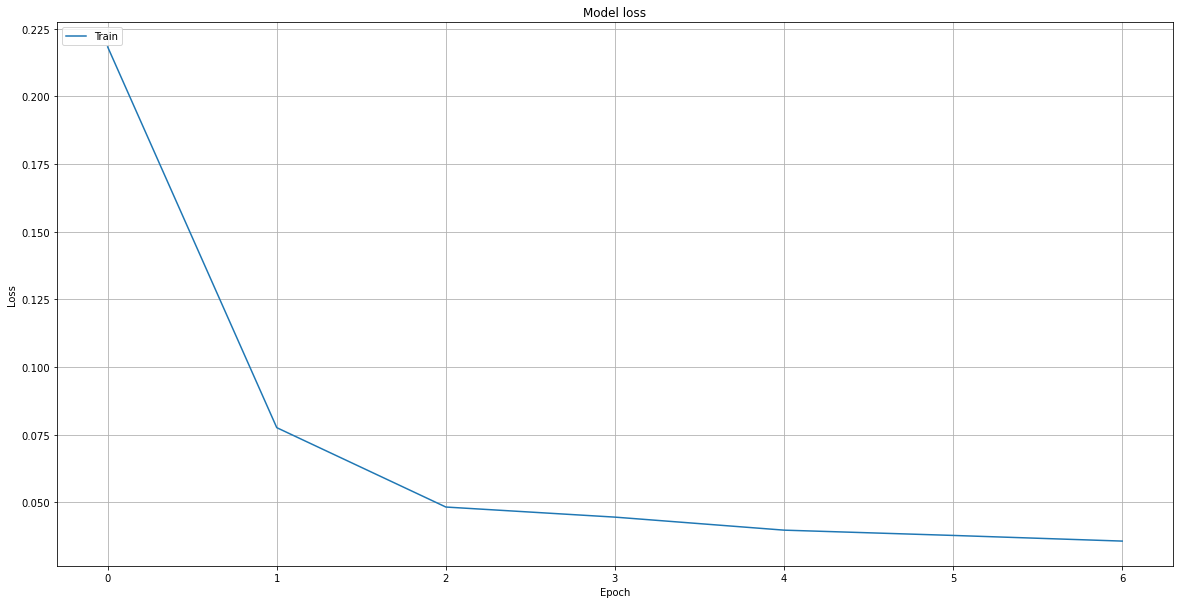

In [73]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [74]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 31.3
Mean Absolute Percentage Error (MAPE): 5.11 %
Median Absolute Percentage Error (MDAPE): 4.86 %


#Result hyperparameter trial and error since no implementation of gridsearch

Sequence Length 20
Epochs 20
Batch size 10
Median Absolute Error (MAE): 36.63
Mean Absolute Percentage Error (MAPE): 6.02 %
Median Absolute Percentage Error (MDAPE): 6.97 %

Sequence Length 20
Epochs 10
Batch size 5
Median Absolute Error (MAE): 27.27
Mean Absolute Percentage Error (MAPE): 4.48 %
Median Absolute Percentage Error (MDAPE): 4.69 %

Sequence Length 10
Epochs 10
Batch size 5
Median Absolute Error (MAE): 22.5
Mean Absolute Percentage Error (MAPE): 3.64 %
Median Absolute Percentage Error (MDAPE): 3.59 %

Sequence Length 20
Epochs 20
Batch size 15    
Median Absolute Error (MAE): 46.47
Mean Absolute Percentage Error (MAPE): 7.6 %
Median Absolute Percentage Error (MDAPE): 8.44 %

    

In [75]:
y_pred

array([[636.6098 ],
       [635.27905],
       [635.22095],
       [637.01337],
       [640.2388 ],
       [643.0964 ],
       [645.8053 ],
       [646.82855],
       [647.8921 ],
       [648.00635],
       [648.2775 ],
       [647.53644],
       [647.24567],
       [646.7652 ],
       [646.4487 ],
       [646.2118 ],
       [646.59705],
       [648.2783 ],
       [649.31805],
       [650.3149 ],
       [651.5485 ],
       [654.07275],
       [657.67914],
       [661.99854],
       [666.93396]], dtype=float32)

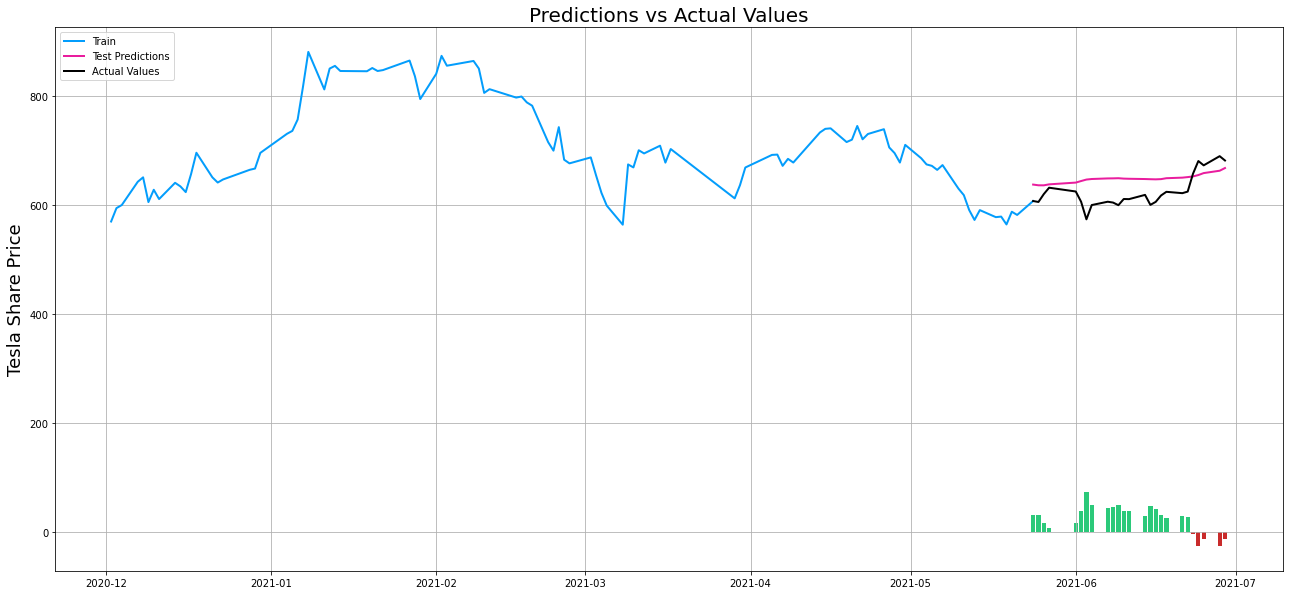

In [76]:
stockname = 'Tesla Share Price'
symbol = '^TSLA'


# The start date 

display_start_date = pd.Timestamp(2020,12,1)


# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = pd.to_datetime(date_index, format='%Y-%m-%d')



# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [77]:
y_test.shape

(25,)

In [78]:
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-25, 1))

In [79]:
y_test_unscaled.shape

(25, 1)

In [80]:
y_train.shape

(90,)

In [81]:
y_train_unscaled = scaler_pred.inverse_transform(y_train.reshape(-90, 1))

In [82]:
def pred_day(d):
    
    df_temp = df[(df['shortdate'] < d) & (df['shortdate'] > d - (sequence_length))]
    #df_temp = df[-sequence_length:]
    new_df = df_temp.filter(FEATURES)

    N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    return pred_price_unscaled

    # Print last price and predicted price for the next day
    price_today = np.round(new_df['Close'][-1], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 2020-12-01 to 2021-06-29
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               125 non-null    float64
 1   Diff                125 non-null    float64
 2   next_day_close      125 non-null    float64
 3   next_day_diff       125 non-null    float64
 4   next_day_plus_diff  125 non-null    int64  
 5   plus_diff           125 non-null    int64  
 6   comment_count       125 non-null    int64  
 7   rocket              125 non-null    int64  
 8   gem                 125 non-null    int64  
 9   clown               125 non-null    int64  
 10  joy                 125 non-null    int64  
 11  hands               125 non-null    int64  
 12  bear                125 non-null    int64  
 13  gorilla             125 non-null    int64  
 14  money_face          125 non-null    int64  
 15  rofl                125 non-null    int64  
 1

In [84]:
df = df.set_index(pd.DatetimeIndex(df.index))#df = df.set_index(pd.DatetimeIndex(df['Datetime']))

In [85]:
given_date = '06-01-2021'


N = sequence_length

date_format = '%m-%d-%Y'
end_date = datetime.strptime(given_date, date_format)
start_date = end_date - timedelta(days=N+7)
print(end_date)
df_temp = df[start_date:end_date]
#df_temp[start_date : end_date]
#df_temp = df.between_time(start_date,end_date)
#df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

#last_N_days = new_df[-sequence_length:].values
#last_N_days_scaled = scaler.transform(new_df)


2021-06-01 00:00:00


In [86]:
df_temp

,Close,Diff,next_day_close,next_day_diff,next_day_plus_diff,plus_diff,comment_count,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,plead,corn,egg,drops,huff,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,BTD,BHSL,HTL,WLTS,ATS
shortdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-17,576.830017,1.280029,577.869995,9.869995,1,1,1225,9,1,11,15,1,7,1,0,9,3,0,1,5,3,1,0,0,0,2,1,0,2,1,0,0,3,0,5,2,1,0,7,2,0,0,3,0,1,0,1,0,0,0,0,0
2021-05-18,577.869995,9.869995,563.460022,10.910034,1,1,1034,15,0,8,9,0,3,1,0,2,2,1,3,6,5,2,1,1,1,0,0,0,0,0,0,0,2,1,2,1,0,0,11,4,2,3,7,1,0,0,0,3,0,0,0,0
2021-05-19,563.460022,10.910034,586.780029,11.780029,1,1,676,5,9,10,11,6,3,0,0,1,1,0,3,2,1,0,1,0,0,0,1,0,1,0,0,0,1,1,4,1,0,0,4,0,3,2,3,2,0,0,0,1,0,0,0,0
2021-05-20,586.780029,11.780029,580.880005,-15.229980,0,1,646,6,2,7,2,2,2,0,0,1,1,0,1,3,0,0,3,2,1,0,0,2,0,0,0,0,3,0,2,4,0,0,2,0,0,0,0,0,0,0,0,3,0,0,0,0
2021-05-21,580.880005,-15.229980,606.440002,24.840027,1,0,742,11,1,9,5,0,2,0,1,1,6,0,2,3,1,0,1,1,1,1,0,0,0,2,1,0,3,1,4,0,0,0,2,0,0,0,2,2,0,0,1,0,0,0,1,0
2021-05-24,606.440002,24.840027,604.690002,-2.619995,0,1,633,17,4,8,2,0,4,1,1,1,2,0,1,4,0,0,2,5,2,0,0,0,1,2,0,0,0,2,2,1,0,0,6,3,3,1,1,0,0,0,0,0,0,0,0,0
2021-05-25,604.690002,-2.619995,619.130005,11.570007,1,0,427,29,2,3,1,2,1,1,1,1,1,1,0,1,2,1,0,0,0,0,1,1,0,0,0,1,1,0,3,0,0,0,5,1,1,0,1,0,0,0,0,2,0,0,1,0
2021-05-26,619.130005,11.570007,630.849976,10.609985,1,1,402,14,1,6,5,1,0,0,1,1,1,0,0,2,7,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,8,1,0,1,0,1,0,0,0,0,0,1,0,0
2021-05-27,630.849976,10.609985,625.219971,-3.280029,0,1,456,9,1,3,3,0,1,0,0,2,1,0,0,4,1,1,2,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,2,0,0,0,0,0,1,0,0,0,0,0


In [87]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [88]:
## Code adapted from example by Rahul Sagrolikar:


def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')


In [89]:
#Refit for XGBOOST
from xgboost import XGBClassifier

In [90]:
X = train_df.drop(['next_day_close','next_day_diff','next_day_plus_diff','Month','Year'], axis= 1)
Y = train_df['next_day_plus_diff']

In [91]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


X_test=X_test[X_train.columns]

In [92]:
X_train

,Close,Diff,plus_diff,comment_count,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,plead,corn,egg,drops,huff,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,BTD,BHSL,HTL,WLTS,ATS
58,668.059998,-32.239990,0,1238,34,18,6,10,4,9,6,2,3,6,3,1,3,0,0,1,1,0,0,1,2,0,0,0,3,6,6,8,4,0,5,10,3,14,2,1,3,2,1,1,3,0,2,0,0
46,781.299988,-13.700012,0,556,25,5,6,2,2,2,1,1,3,2,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,2,2,5,0,0,2,4,5,3,0,0,1,0,0,0,0,0,0,0,0
45,787.380005,6.479980,1,619,14,2,4,2,1,2,1,1,1,2,1,3,0,0,1,1,1,0,1,0,0,0,0,0,0,0,3,3,0,0,1,4,3,2,0,0,1,0,0,0,3,0,1,1,0
12,655.900024,27.710022,1,1918,36,4,8,7,1,9,0,5,5,8,1,4,6,3,1,5,4,5,0,1,3,0,5,3,1,7,8,23,15,0,0,14,11,17,2,1,2,6,2,0,1,0,0,0,0
119,623.710022,5.460022,1,160,2,0,1,3,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
11,622.770020,-5.459961,0,1654,27,5,9,3,0,8,0,2,2,6,1,3,3,6,0,1,2,1,0,0,5,0,0,0,6,7,5,24,5,0,0,16,12,17,1,2,4,4,5,4,5,0,2,0,0
84,709.440002,41.849976,1,92,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
95,576.830017,1.280029,1,1225,9,1,11,15,1,7,1,0,9,3,0,1,5,3,1,0,0,0,2,1,0,2,1,0,0,3,0,5,2,1,0,7,2,0,0,3,0,1,0,1,0,0,0,0,0
18,665.989990,4.989990,1,655,18,2,2,3,0,1,0,0,0,0,0,1,2,1,0,3,1,4,0,0,1,0,2,0,0,2,1,8,2,0,0,4,3,5,0,0,1,1,0,0,1,0,0,0,0
50,682.219971,-43.930054,0,1225,48,17,5,8,8,4,6,4,5,5,4,2,1,1,2,1,1,4,0,1,1,0,2,1,1,5,2,10,1,2,2,21,6,13,1,0,0,1,3,0,6,0,1,0,0


In [93]:
final_df, final_vif = iterate_vif(X_train)

Iteration # 1
Removing comment_count with VIF of 291.832782
Iteration # 2
Removing rainbow with VIF of 93.256963
Iteration # 3
Removing gem with VIF of 92.639453
Iteration # 4
Removing rocket with VIF of 40.062843
Iteration # 5
Removing hands with VIF of 36.735675
Iteration # 6
Removing MOON with VIF of 33.129334
Iteration # 7
Removing TENDIES with VIF of 26.352724
Iteration # 8
Removing YOLO with VIF of 22.677246
Iteration # 9
Removing bear with VIF of 22.532168
Iteration # 10
Removing joy with VIF of 20.661239
Iteration # 11
Removing DIAMONDHANDS with VIF of 17.636062
Iteration # 12
Removing FD with VIF of 16.193432
Iteration # 13
Removing cry with VIF of 15.364815
Iteration # 14
Removing clown with VIF of 13.712265
Iteration # 15
Removing STONKS with VIF of 12.177820
Iteration # 16
Removing think with VIF of 10.269270
Iteration # 17
Removing DD with VIF of 9.179583
Iteration # 18
Removing Close with VIF of 8.372046
Iteration # 19
Removing PAPERHANDS with VIF of 7.593116
Iteration # 

In [94]:
X_train = final_df
X_test=X_test[X_train.columns] 


In [95]:

# fit model to training data
model = XGBClassifier()


param_grid = {'learning_rate': [0.01,0.007,0.005,0.002,0.001], 
              'max_depth': [2,3,4,5,6],
              'seed': [2,3,4,5]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)




Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   20.5s


[18:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nan
{'learning_rate': 0.007, 'max_depth': 6, 'seed': 2}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.7s finished
C:\Users\carl_\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\carl_\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [96]:
xgb1=XGBClassifier(learning_rate = 0.007, max_depth = 6, seed = 2)
xgb1.fit(X_train, y_train.values.ravel())



[18:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.007, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [97]:
pred = xgb1.predict(X_test)

In [98]:
print("Accuracy for XGB Classifier on CV data: ",accuracy_score(y_test,pred))

Accuracy for XGB Classifier on CV data:  0.5625


In [99]:
print ('ROC AUC Score',roc_auc_score(y_test,pred))

ROC AUC Score 0.5714285714285714


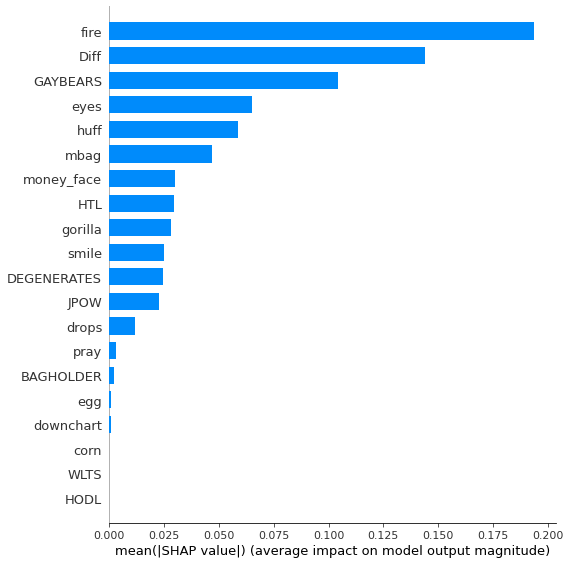

In [100]:
import shap 
shap_values = shap.TreeExplainer(xgb1).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [101]:
y_test

109    0
100    0
99     1
82     0
40     0
22     1
41     0
49     0
5      0
116    1
97     1
52     0
85     0
66     0
71     1
108    0
65     1
13     0
122    1
26     1
107    1
124    0
51     1
59     1
43     1
15     1
106    1
20     1
93     1
76     1
114    1
81     0
Name: next_day_plus_diff, dtype: int64

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression

def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression(max_iter=10000)
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

Accuracy of logistic regression classifier on test set: 0.53

Confusion matrix: 
 [[8 6]
 [9 9]]

Classification report: 
               precision    recall  f1-score   support

           0       0.47      0.57      0.52        14
           1       0.60      0.50      0.55        18

    accuracy                           0.53        32
   macro avg       0.54      0.54      0.53        32
weighted avg       0.54      0.53      0.53        32



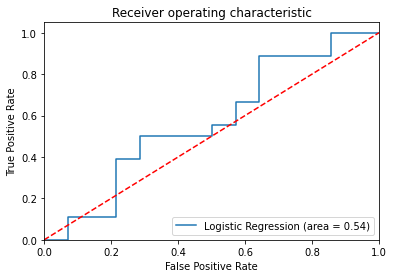

In [103]:
logreg = run_regression_accuracy(X_train, y_train.values.ravel(), X_test, y_test)